In [1]:
import numpy as np
import pandas as pd
import scipy.stats as sps
from matplotlib import pyplot as plt
import plotly.graph_objs as go
import seaborn as sns

# Часть 1
Реализовать формулу подсчета длительности теста, сравнить ее с онлайн калькуляторами (например https://mindbox.ru/tools/ab-test-calculator/ ). При сравнении оценить мощность критерия при указанном изменении и рассчитанном количестве наблюдений в выборке. 



In [2]:
def duration(k, delta_effect, sigma_1, sigma_2, alpha=0.05, beta=0.2):
    z = sps.norm.ppf(1 - alpha/2) + sps.norm.ppf(1-beta)
    n = (k+1) * z ** 2 * (sigma_1 ** 2 + sigma_2 **2 / k) / (delta_effect ** 2)
    return n

In [3]:
ALPHA = 0.05
K = 1
N_SAMPLES = 10000

In [4]:
def get_p_value_power(p_values, alpha):
    p_values = np.array(p_values)
    return len(p_values[p_values < alpha]) / len(p_values) * 100

In [5]:
def get_duration_power(k, delta_effect, p, alpha, beta, n_samples=N_SAMPLES):
    sigma1 = np.sqrt(p * (1 - p))
    sigma2 = np.sqrt((p + delta_effect) * (1 - p - delta_effect))
    
    duration_value = duration(k, delta_effect, sigma1, sigma2, alpha, beta)
 
    p_values = []
    for _ in range(n_samples):
        data1 = sps.bernoulli.rvs(p=p, size=int(duration_value) // 2)
        data2 = sps.bernoulli.rvs(p=p + delta_effect, size=int(duration_value) // 2)
        
        p_value = sps.ttest_ind(data1, data2, equal_var=False).pvalue
        p_values.append(p_value)
    
    criterion_power = get_p_value_power(p_values, alpha)

    return duration_value, criterion_power

In [6]:
alpha = ALPHA
k = K

p = 0.2
delta_effect = 0.07
beta = 0.2
result = get_duration_power(k, delta_effect, p, alpha, beta)
print(f'Duration: {int(result[0])}, power: {result[1]}%')

Duration: 1144, power: 79.66%


![mindbox №1](screens/1.png)

In [7]:
p = 0.2
delta_effect = 0.1
beta = 0.1
result = get_duration_power(k, delta_effect, p, alpha, beta)
print(f'Duration: {int(result[0])}, power: {result[1]}%')

Duration: 777, power: 89.64999999999999%


![mindbox №3](screens/3.png)

In [8]:
p = 0.2
delta_effect = 0.05
beta = 0.2
result = get_duration_power(k, delta_effect, p, alpha, beta)
print(f'Duration: {int(result[0])}, power: {result[1]}%')

Duration: 2181, power: 79.45%


![mindbox №4](screens/4.png)

In [9]:
p = 0.2
delta_effect = 0.01
beta = 0.1
result = get_duration_power(k, delta_effect, p, alpha, beta)
print(f'Duration: {int(result[0])}, power: {result[1]}%')

Duration: 68487, power: 89.66%


![mindbox №5](screens/5.png)

Размер выборки, посчитанной по формуле незначительно отличается (~5-10%) от калькулятора

## Часть 2.
Реализовать метод линеаризации. Проверить для него корректность и мощность. Мощность должна быть больше, чем просто на обычных значениях конверсии пользователей.


In [10]:
def get_qq_plot(p_values, p_values2, method='Линеаризация'):
    """Рисует распределение p-value"""
    p_values = np.array(p_values)
    p_values2 = np.array(p_values2)
    power = get_p_value_power(p_values, alpha=ALPHA)
    power2 = get_p_value_power(p_values2, alpha=ALPHA)
    probs = []
    probs2 = []

    x = [0.01 * i for i in range(101)]
    for i in range(101):
        alpha_step = 0.01 * i
        probs.append(get_p_value_power(p_values, alpha_step) / 100)
        probs2.append(get_p_value_power(p_values2, alpha_step) / 100)

    fig, axs = plt.subplots(1, 2, figsize=(15, 5))
    sns.set_style("darkgrid")
    sns.scatterplot(x=x, y=probs, ax=axs[0])
    sns.lineplot(x=x, y=x, color='r', ax=axs[0])
    axs[0].set_title(f'Мощность: {round(power, 3)}%')

    sns.scatterplot(x=x, y=probs2, ax=axs[1])
    sns.lineplot(x=x, y=x, color='r', ax=axs[1]);
    axs[1].set_title(f'{method}. Мощность: {round(power2, 3)}%')

In [11]:
def linearization(loc1, loc2, scale1, scale2, effect=0.005):
    n_exp = 1000
    p_values = []
    p_values_lin = []
    for _ in range(n_exp):
        records = []
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=loc1, scale=scale1))
            clicks = sps.bernoulli.rvs(p=0.05, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "A"])
        for i in range(100):
            n_views = int(sps.expon.rvs(loc=loc2, scale=scale2))
            clicks = sps.bernoulli.rvs(p=0.05 + effect, size=n_views)
            records.append([n_views, np.sum(clicks), np.sum(clicks)/ n_views, "B"])
        df_data = pd.DataFrame(records, columns=["views", "clicks", "cr", "group"])
        
        cr_A = df_data[df_data["group"] == "A"]["clicks"].sum() / df_data[df_data["group"] == "A"]["views"].sum()
        df_data["cr_lin"] = df_data["clicks"] - cr_A * df_data["views"]

        x_a = df_data[df_data["group"] == "A"]["cr"]
        x_b = df_data[df_data["group"] == "B"]["cr"]
        p_value = sps.ttest_ind(x_a, x_b).pvalue
        p_values.append(p_value)
        
        x_a_lin = df_data[df_data["group"] == "A"]["cr_lin"]
        x_b_lin = df_data[df_data["group"] == "B"]["cr_lin"]
        p_value_lin = sps.ttest_ind(x_a_lin, x_b_lin).pvalue
        p_values_lin.append(p_value_lin)
        
    get_qq_plot(p_values, p_values_lin, 'Линеаризация')

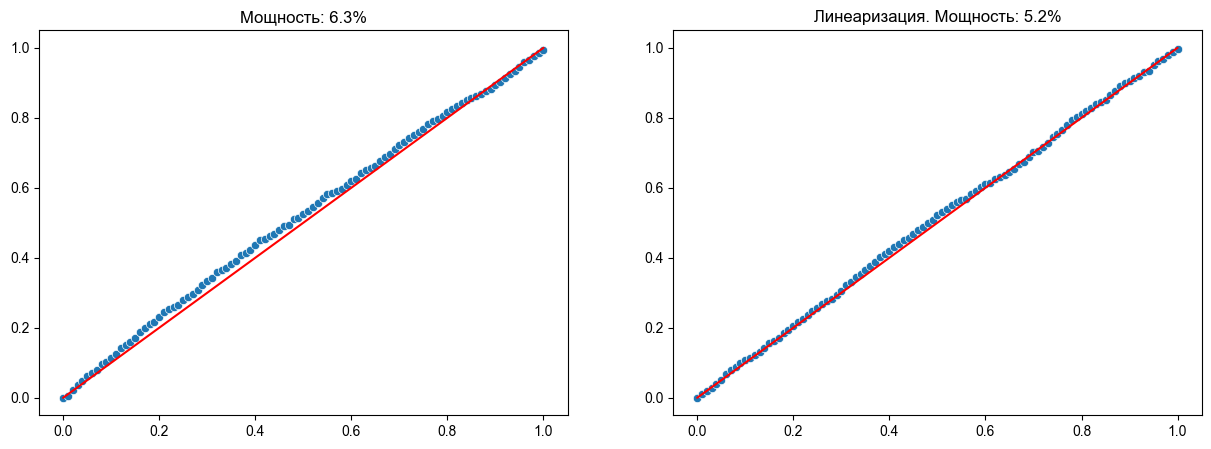

In [12]:
linearization(1, 1, 1, 1)

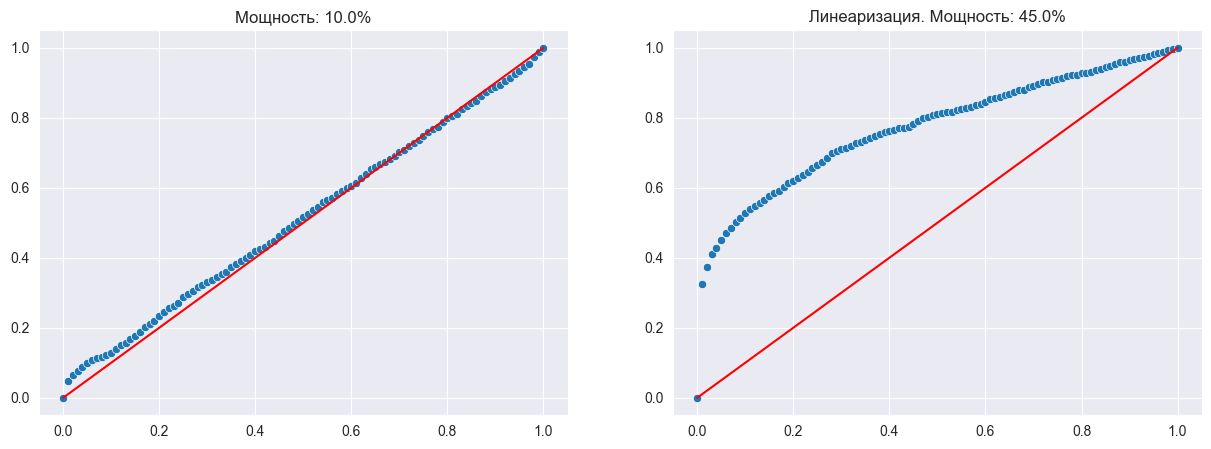

In [13]:
linearization(1, 10, 1, 1)


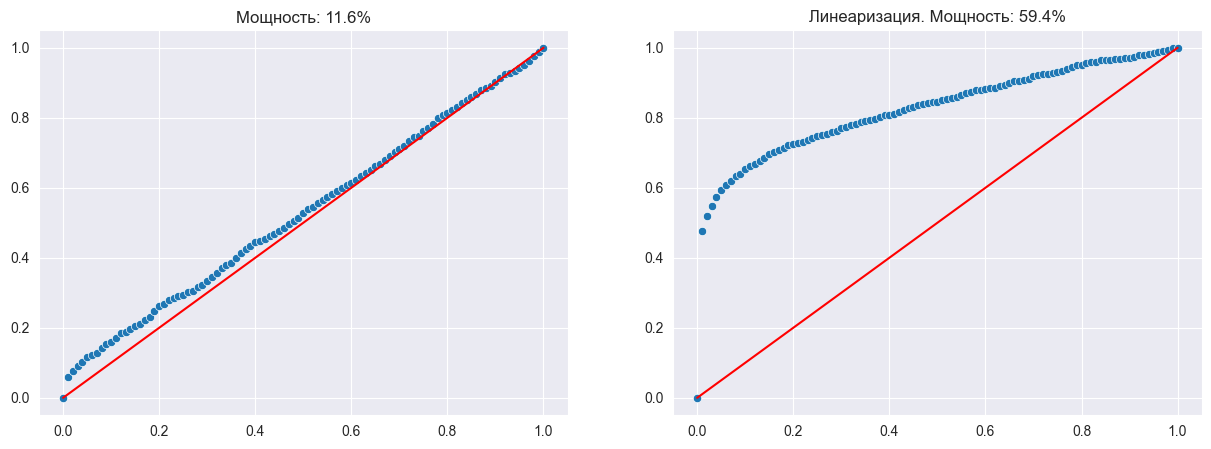

In [14]:
linearization(1, 10, 1, 10)

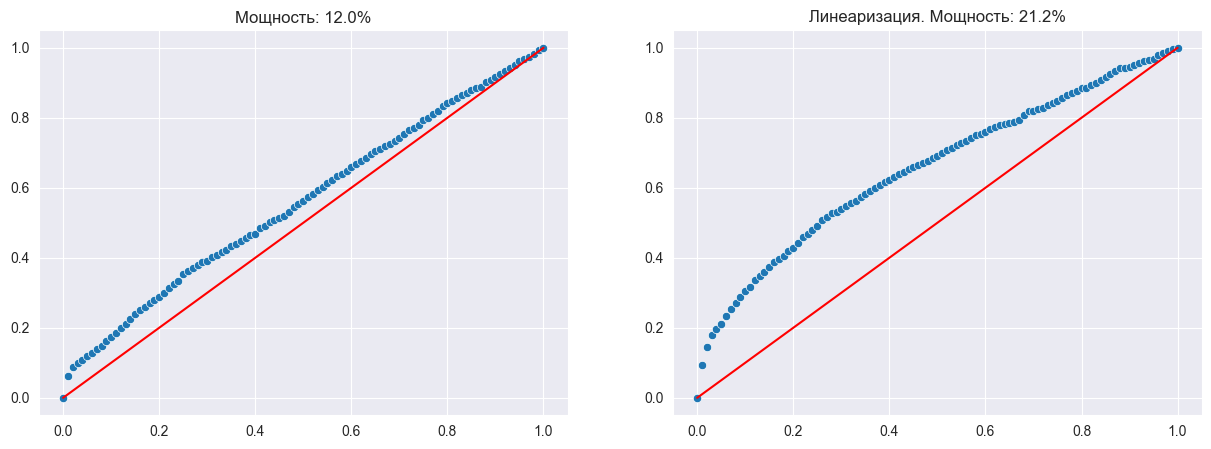

In [15]:
linearization(1, 10, 10, 10)

Мощность у линеаризации выше

# Часть 3

Реализовать метод CUPED. Проверить для него корректность и мощность. Данные на этапе до A/B тесте необходимо сгенерировать один раз, далее синтетически генерировать только часть, связанную с проведением A/B-теста.

In [16]:
size = 10000
loc_init = 100
scale_init = 20
pre_exp = sps.norm.rvs(loc_init, scale_init, size=size)

In [17]:
n_exp = 1000
loc_effect = 1
scale_exp = 100
p_values = []
p_values_cuped = []

for _ in range(n_exp):
    df_A = pd.DataFrame()
    df_A["user"] = [f"A_{x:5}" for x in range(size)]
    df_A["pre_exp"] = pre_exp
    df_B = pd.DataFrame()
    df_B["pre_exp"] = pre_exp
    df_B["user"] = [f"B_{x:5}" for x in range(size)]
    df_A["payments"] = sps.expon.rvs(loc=loc_init, scale=scale_exp, size=size) * df_A["pre_exp"]
    df_B["payments"] = sps.expon.rvs(loc=loc_init + loc_effect, scale=scale_exp, size=size) * df_B["pre_exp"]

    p_values.append(sps.ttest_ind(df_A["payments"], df_B["payments"]).pvalue)

    x_a = df_A["pre_exp"]
    x_b = df_B["pre_exp"]
    y_a = df_A["payments"]
    y_b = df_B["payments"]
    theta = np.cov(x_a, y_a)[0,1] / np.std(x_a)**2

    df_A["payments_cuped"] = df_A["payments"] - theta * df_A["pre_exp"]
    df_B["payments_cuped"] = df_B["payments"] - theta * df_B["pre_exp"]

    p_values_cuped.append(sps.ttest_ind(df_A["payments_cuped"], df_B["payments_cuped"]).pvalue)

    power = get_p_value_power(p_values, ALPHA)
    power_cuped = get_p_value_power(p_values_cuped, ALPHA)
    
print(f"Power: {power}, power with CUPED: {power_cuped}")


Power: 8.0, power with CUPED: 11.1


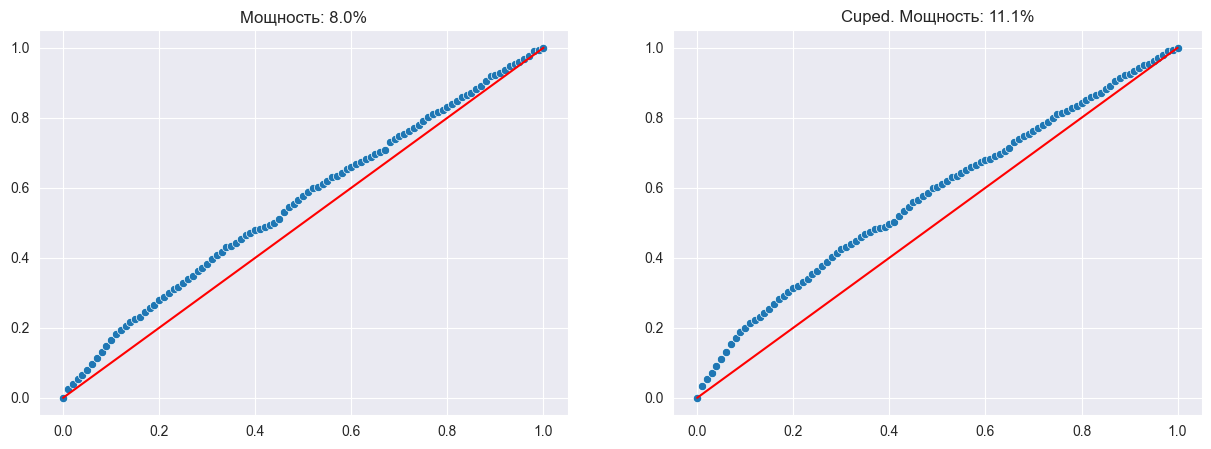

In [18]:
get_qq_plot(p_values, p_values_cuped, method='Cuped')
